In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
metadata_dir = 'updated_metadata.csv'

annotations = pd.read_csv(metadata_dir)

# Distribución de los datos teniendo en cuenta el hallazgo

In [79]:
def zip_by_column(column: str) -> dict[str, dict]:
    split_distribution: dict[str, dict] = {}
    for column_values, split in zip(annotations[column], annotations['split']):
        split_distribution.setdefault(split, {})
        column_value = eval(column_values) if column == 'finding_categories' else [ column_values ]
        for category in column_value:
            category = str(category)
            split_distribution[split].setdefault(category, int(0))
            split_distribution[split][category] += 1
    return split_distribution

In [80]:
split_finding_distribution = zip_by_column('finding_categories')

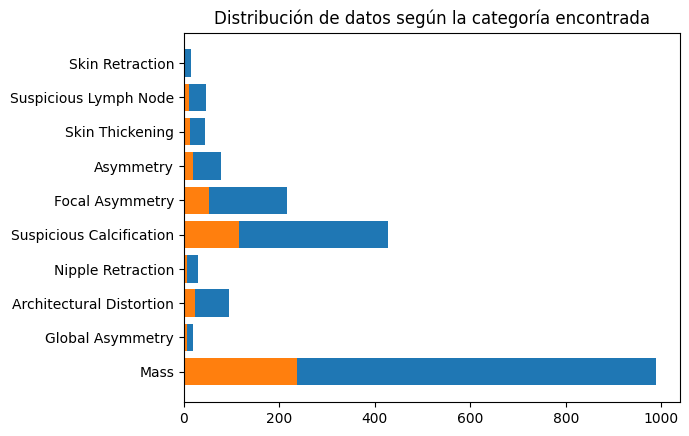

In [81]:
for split in split_finding_distribution:
    if 'No Finding' in split_finding_distribution[split]:
        del split_finding_distribution[split]['No Finding']

fig, ax = plt.subplots()
ax.set_title('Distribución de datos según la categoría encontrada')

height = 0.8
for boolean, weight_count in split_finding_distribution.items():
    ax.barh(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

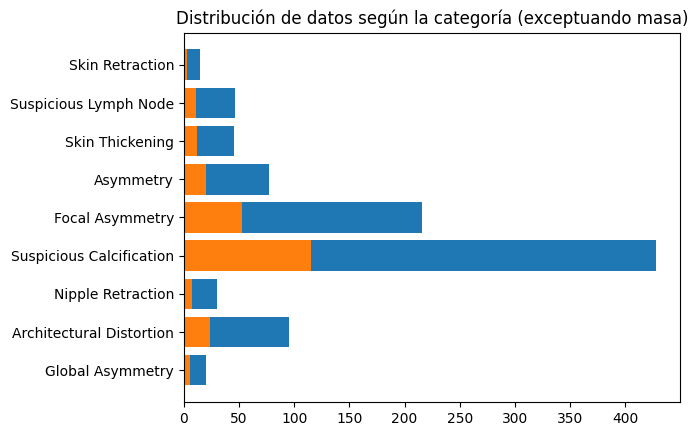

In [86]:
for split in split_finding_distribution:
    if 'Mass' in split_finding_distribution[split]:
        del split_finding_distribution[split]['Mass']

fig, ax = plt.subplots()
ax.set_title('Distribución de datos según la categoría (exceptuando masa)')

height = 0.8
for boolean, weight_count in split_finding_distribution.items():
    ax.barh(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

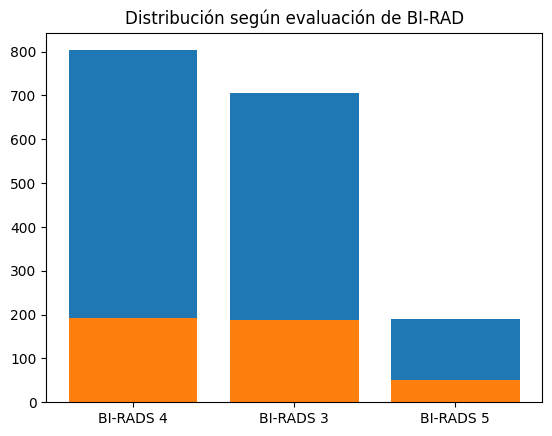

In [85]:
split_birads_distribution = zip_by_column('finding_birads')

for split in split_birads_distribution:
    if 'nan' in split_birads_distribution[split]:
        del split_birads_distribution[split]['nan']

fig, ax = plt.subplots()
ax.set_title('Distribución según evaluación de BI-RAD')

height = 0.8
for boolean, weight_count in split_birads_distribution.items():
    ax.bar(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

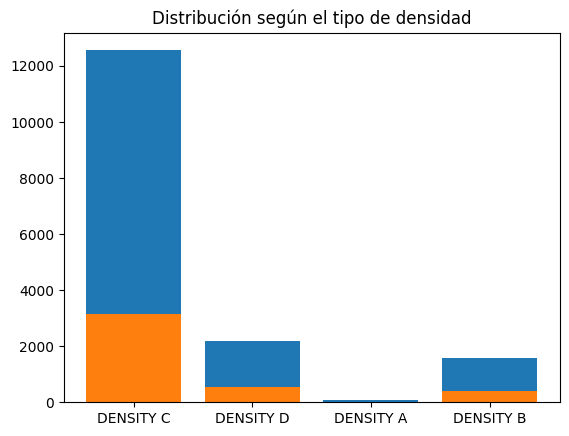

In [106]:
split_density_distribution = zip_by_column('breast_density')

# for split in split_density_distribution:
#     if 'nan' in split_density_distribution[split]:
#         del split_density_distribution[split]['nan']

fig, ax = plt.subplots()
ax.set_title('Distribución según el tipo de densidad')

height = 0.8
for boolean, weight_count in split_density_distribution.items():
    ax.bar(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()

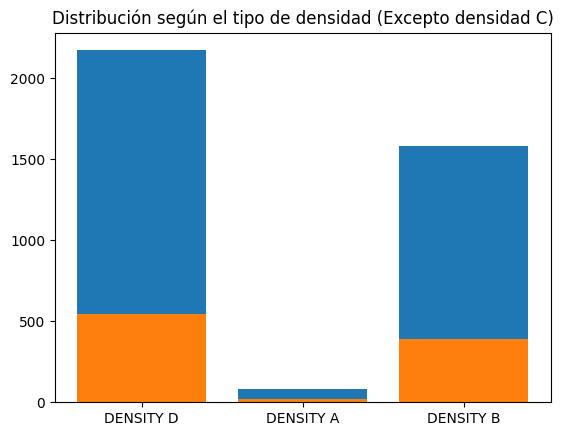

In [88]:
for split in split_density_distribution:
    if 'DENSITY C' in split_density_distribution[split]:
        del split_density_distribution[split]['DENSITY C']

fig, ax = plt.subplots()
ax.set_title('Distribución según el tipo de densidad (Excepto densidad C)')

height = 0.8
for boolean, weight_count in split_density_distribution.items():
    ax.bar(weight_count.keys(), weight_count.values(), height, label=boolean)
plt.show()